## Project: AI ologist




In [46]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    class_files = np.array(data['filenames'])
    class_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return class_files, class_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(r'C:\Akshay\Train\Applications\Anaconda3\Projects\OCR Tesseract\datasetForArch\train')
valid_files, valid_targets = load_dataset(r'C:/Akshay/Train/Applications/Anaconda3/Projects/OCR Tesseract/datasetForArch/valid')
test_files, test_targets = load_dataset(r'C:/Akshay/Train/Applications/Anaconda3/Projects/OCR Tesseract/datasetForArch/test')

# load list of dog names
class_names = [item[51:-1] for item in sorted(glob("C:/Akshay/Train/Applications/Anaconda3/Projects/OCR Tesseract/datasetForArch/train/*/"))]

# print statistics about the dataset
print('There are %d total class categories.' % len(class_names))
print('There are %d total class images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training human images.' % len(train_files))
print('There are %d validation human images.' % len(valid_files))
print('There are %d test human images.'% len(test_files))
print((class_names))

There are 2 total class categories.
There are 827 total class images.

There are 540 training human images.
There are 128 validation human images.
There are 159 test human images.
[' Tesseract/datasetForArch/train\\Cat', ' Tesseract/datasetForArch/train\\Dogs']



## Step 2: Create a CNN to Classify Cats or Dogs (from Scratch)


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [47]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(400, 400))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    #TQDM will display Progress Bar 
    return np.vstack(list_of_tensors)

In [48]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 159/159 [00:01<00:00, 109.28it/s]


## Image Augmentation

In [49]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    rotation_range=40, #Rotate
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

## Define my own architecture

In [50]:
#CNN Basic Libs
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
#Core Libs
from keras.layers import Dropout, Flatten, Dense, Activation
#Load Model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

#Loading Sequential CNN Model
model = Sequential()
#Input shape 400*400 and 3 Channels
#Batch Normalization to standardize input and accelerate training
model.add(BatchNormalization(input_shape=(400, 400, 3)))
#Initialize filters to 16 , 3x3 , normal kernal , y =(max(0,y)) relu
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
#Pool window 2 / 2 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 400, 400, 3)       12        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 398, 398, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 199, 199, 16)      0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 199, 199, 16)      64        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 197, 197, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 98, 98, 32)       

### Compile the Model

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Train the Model

We train our model in the code cell below.  Notice that I am using model checkpointing to save the model that attains the best validation loss.

In [52]:
from keras.callbacks import ModelCheckpoint  

#5 pass over entire data set
epochs = 5
batch_size = 100

checkpointer = ModelCheckpoint(filepath='weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
5/5 [==============================] - ETA: 1:58 - loss: 0.9136 - accuracy: 0.41 - ETA: 1:13 - loss: 0.9276 - accuracy: 0.52 - ETA: 38s - loss: 0.9929 - accuracy: 0.5417 - ETA: 19s - loss: 1.0079 - accuracy: 0.564 - 105s 21s/step - loss: 0.9703 - accuracy: 0.5773 - val_loss: 0.6912 - val_accuracy: 0.5703

Epoch 00001: val_loss improved from inf to 0.69118, saving model to weights.bestaugmented.from_scratch.hdf5
Epoch 2/5
5/5 [==============================] - ETA: 1:17 - loss: 0.8794 - accuracy: 0.57 - ETA: 59s - loss: 0.9856 - accuracy: 0.5400 - ETA: 39s - loss: 0.9257 - accuracy: 0.536 - ETA: 20s - loss: 0.8634 - accuracy: 0.542 - 96s 19s/step - loss: 0.8611 - accuracy: 0.5455 - val_loss: 0.9771 - val_accuracy: 0.5703

Epoch 00002: val_loss did not improve from 0.69118
Epoch 3/5
5/5 [==============================] - ETA: 1:16 - loss: 0.6517 - accuracy: 0.67 - ETA: 58s - loss: 0.7224 - accuracy: 0.6450 - ETA: 39s - loss: 0.7292 - accuracy: 0.636 - ETA: 19s - loss: 0.7024 - 

### Load the Model with the Best Validation Loss

In [53]:
model.load_weights('weights.bestaugmented.from_scratch.hdf5')

### Test the Model

Let's try out our model on the test dataset of test images. This will be our "test accuracy". 

In [54]:
# get index of predicted dog breed for each image in test set
class_probability = [(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
class_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(class_predictions)==np.argmax(test_targets, axis=1))/len(class_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 62.8931%


In [93]:
import pandas as pd

y = pd.DataFrame()
for i in range(0,len(class_probability)):
    x = class_probability[i]
    x = pd.DataFrame(x)
    y = y.append(x)

y.columns = ['Emphysema_prob' , 'No_finding_prob']
y = y.reset_index(drop=True)
#y.head()

#test_labels
test_label = pd.DataFrame()
for i in range(0,len(test_targets)):
    x = np.transpose(pd.DataFrame(test_targets[i]))
    test_label = test_label.append(x)

test_label.head()
test_label.columns = ['Emphysema' , 'No_finding']
test_label = test_label.reset_index(drop=True)

y = pd.concat([y.reset_index(drop=True), test_label], axis=1)
y.head()

y.to_csv('matrix.csv')

In [94]:
#setting the threshold
y['No_finding_predicted'] = np.where(y.No_finding_prob > 0.96, 1, 0)
y.head()

from sklearn.metrics import confusion_matrix
confusion_matrix(y.No_finding_predicted, y.No_finding)

array([[141, 215],
       [  1,  35]], dtype=int64)

### Prediction on xrays

Predicting what the scan is.

In [15]:
### This function takes a path to an image as input
### and returns the gender that is predicted by the model.

import cv2
import matplotlib.pyplot as plt
import numpy as np

def model_predict_class(img_path):
    # obtain predicted vector
    predicted_vector = model.predict((path_to_tensor(img_path).astype('float32')/255))
    # return gender that is predicted by the model
    class_image = class_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    print("The class of scan is {}".format(class_image))

The class of scan is No_finding


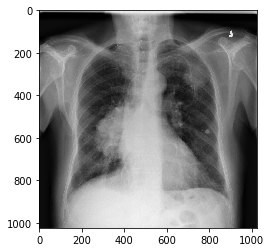

In [16]:
model_predict_class("C:/Users/rohit/Desktop/Alpha Project/CV/Data/test/Emphysema/00015242_000.png")

### More Training
We can resume training to see if accuracy improves

In [17]:
batch_size = 150
epochs = 10

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/10
20/20 [==============================] - ETA: 11:27 - loss: 0.5618 - acc: 0.74 - ETA: 10:18 - loss: 0.5681 - acc: 0.73 - ETA: 9:50 - loss: 0.5512 - acc: 0.7356 - ETA: 8:59 - loss: 0.5289 - acc: 0.756 - ETA: 8:15 - loss: 0.5315 - acc: 0.752 - ETA: 7:36 - loss: 0.5286 - acc: 0.747 - ETA: 7:02 - loss: 0.5274 - acc: 0.740 - ETA: 6:27 - loss: 0.5248 - acc: 0.740 - ETA: 5:52 - loss: 0.5405 - acc: 0.725 - ETA: 5:19 - loss: 0.5420 - acc: 0.724 - ETA: 4:46 - loss: 0.5435 - acc: 0.724 - ETA: 4:13 - loss: 0.5421 - acc: 0.724 - ETA: 3:41 - loss: 0.5425 - acc: 0.728 - ETA: 3:10 - loss: 0.5395 - acc: 0.734 - ETA: 2:40 - loss: 0.5371 - acc: 0.734 - ETA: 2:09 - loss: 0.5365 - acc: 0.736 - ETA: 1:37 - loss: 0.5363 - acc: 0.735 - ETA: 1:05 - loss: 0.5359 - acc: 0.735 - ETA: 33s - loss: 0.5336 - acc: 0.736 - 687s 34s/step - loss: 0.5330 - acc: 0.7380 - val_loss: 0.6628 - val_acc: 0.6005

Epoch 00001: val_loss did not improve from 0.62758
Epoch 2/10
20/20 [==============================] - ETA:

KeyboardInterrupt: 

In [ ]:
model.load_weights('weights.bestaugmented.from_scratch.hdf5')

## Test the Model Again
After we test the model again we see that we have improved the test accuracy to 92.05%

In [ ]:
# get index of predicted dog breed for each image in test set
class_probability = [(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
class_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(class_predictions)==np.argmax(test_targets, axis=1))/len(gender_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step6'></a>
## Step 6: Test Disease Classifier Algorithm

In this section, we will take our algorithm for a spin!  

### Test Your Algorithm on Scans!

## Results from my Disease Classifier

In [ ]:
#from gtts import gTTS
#import os    
#
#tts_lady = gTTS(text="We have detected a pretty lady", lang='en')
#tts_lady.save("lady.mp3")
#tts_man = gTTS(text="We have detected a gentleman", lang='en')
#tts_man.save("Gentleman.mp3")
#tts_none = gTTS(text="This is not a human being", lang='en')
#tts_none.save("none.mp3")

In [ ]:
### This function takes a path to an image as input
### and returns the gender that is predicted by the model.

#def model_predict_gender_self(img_path):
#    # obtain predicted vector
#    predicted_vector = model.predict((path_to_tensor(img_path).astype('float32')/255))
#    # return gender that is predicted by the model
#    gender = human_names[np.argmax(predicted_vector)]
#    img = cv2.imread(img_path)
#    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    imgplot = plt.imshow(cv_rgb)
#    print("The gender of human is {}".format(gender))
#    if (gender) == "men":
#        os.system("Gentleman.mp3")
#    if (gender) == "none":
#        os.system("none.mp3")
#    if (gender) == "women":
#        os.system("lady.mp3")

In [ ]:
#taking image from laptop
#import cv2
#camera = cv2.VideoCapture(0)
#from gtts import gTTS
#import os
#
#
#for i in range(1):
#    return_value, image_self = camera.read()
#    cv2.imwrite('opencv'+str(i)+'.jpg', image_self)
#del(camera)